# ConvNEXT for DR detection on MESSIDOR-2 Dataset

#### References:
[1] Liu, Z., Mao, H., Wu, C.Y., Feichtenhofer, C., Darrell, T. and Xie, S., 2022. *A convnet for the 2020s*. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 11976-11986)

[2] Aravind Eye Hospital, *APTOS 2019 blindness detection*,
https://www.kaggle.com/c/aptos2019‐blindness‐detection

[3] Debayan Mitra, Blindness detection (Diabetic retinopathy) using Deep learning on Eye retina images, https://towardsdatascience.com/blindness‐detection‐diabetic‐retinopathy‐using‐deep‐learning‐on‐eye‐retina‐images‐baf20fcf409e

[4] Jacob Gildenblat and contributors, PyTorch library for CAM methods, 202, GitHub, https://github.com/jacobgil/pytorch-grad-cam


## Setup

To setup the dataset, run the "Dataset Download" and "Environment Setup" cells. 

### Google Drive Access

In [12]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/MESSIDOR-2'
PREP_PATH = DATASET_PATH + '/preprocessed/'
MODEL_PATH= '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/MESSIDOR-2/checkpoints/checkpoint_convnext.pth'

# Load Dataset From Drive
drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists(DATASET_PATH + "/checkpoints"):
  os.mkdir(DATASET_PATH + "/checkpoints")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/MESSIDOR-2


### Dataset Download

In [ ]:
'''# Dataset with already preprocessed images
!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC
!unzip APTOS2019.zip

# Parameters
DATASET_PATH = '/content/MESSIDOR-2'
PREP_PATH = DATASET_PATH + "/preprocessed/"
MODEL_PATH= '/content/MESSIDOR-2/checkpoints/checkpoint_convnext.pth'

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists("/checkpoints"):
  os.mkdir("/checkpoints")
  '''


'\n# Dataset with already preprocessed images\n!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC\n!unzip APTOS2019.zip\n\n# Parameters\nDATASET_PATH = \'/content/APTOS2019\'\nPREP_PATH = DATASET_PATH + "/preprocessed/"\nMODEL_PATH= \'/content/checkpoints/checkpoint.pth\'\n\nif not os.path.exists(PREP_PATH):\n  os.mkdir(PREP_PATH)\n\nif not os.path.exists("/checkpoints"):\n  os.mkdir("/checkpoints")\n'

### Environment Setup

In [2]:
!pip install torchinfo
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.3-py3-none-any.whl size=32263 sha256=fb8fc312cb8574ec5ff1ab96ccd4d959d5c71a24065dc40b09559cd418c1aef2
  Stored in directory: /root/.cache/pip/wheels/77/05/47/36e06c7cdf46685b5a9e30686a1f93bff3e95a91bf1404c75d
Successfully built grad-cam


## Imports and global parameters

In [3]:
import pandas as pd
import cv2
import numpy as np
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import torchvision
from torchvision.models import ConvNeXt_Tiny_Weights
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 
%matplotlib inline

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"

In [4]:
# Model Hyperparameters

IMG_SIZE = 512
N_CHANNELS = 3
BATCH_SIZE = 10

# Number of epochs for the batch training
NUM_EPOCHS = 30
# Number of epochs for the warmup training
NUM_INIT_EPOCHS = 4
# Learning Rate for the warmup training
LR_INIT = 0.00001
# Learning Rate for the batch training
LR = 0.0001

# LR Reduction Factor 
DECAY_FACTOR = 0.1
# Minimum Learning Rate for LR Reduction on Plateau
LR_TSH = 0.000001
# Number of epochs to wait before LR reduction 
# when no improvement is detected
PATIENCE = 1

# Number of epochs to wait before Early Stopping 
# when no improvement is detected
ES_PATIENCE = 3

N_CLASSES = 5
CLASSES = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

# Maximum number of CPU cores available for faster preprocessing
N_CORES = 4

## Dataset Preparation

In [5]:
'''
# The label file for messidor-2 follows a different structure compared to the one for APTOS19
# This code performs some refactoring on the .csv

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

messidor = pd.read_csv('messidor_data.csv') 

messidor.rename(columns={"image_id": "id_code"}, inplace=True)
messidor.rename(columns={"adjudicated_dr_grade": "diagnosis"}, inplace=True)
messidor.drop("adjudicated_dme", inplace=True, axis=1)
messidor.drop("adjudicated_gradable", inplace=True, axis=1)
messidor['id_code'] = messidor['id_code'].str.replace('.jpg','.JPG')
messidor.dropna(inplace=True)
messidor.to_csv('messidor_data.csv')  
'''

CWD: /content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/MESSIDOR-2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


In [7]:
# Code for circle-crop simplified and adapted from [3]

from google.colab.patches import cv2_imshow

def crop_image_from_gray(img,tol=7):
  mask = img>tol

  img1=img[np.ix_(mask.any(1),mask.any(0))]
  img2=img[np.ix_(mask.any(1),mask.any(0))]
  img3=img[np.ix_(mask.any(1),mask.any(0))]
  img = np.stack([img1,img2,img3],axis=-1)

  return img

def circle_crop(img):   
    height, width = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

def preprocess(id_code):
  # Retrieve image path
  path = DATASET_PATH + "/IMAGES/" + id_code

  # Check if image exists, this way any missing files can 
  # be manually uploaded
  if(os.path.isfile(path) == False):
    print("WARNING: ", path + " does not exist!")
    return

  # Read image
  img = cv2.imread(path)

  # Extract Green Channel
  img = img[:,:,1]

  #CLAHE
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  img = clahe.apply(img)

  # Circle crop
  img = circle_crop(img)

  # Resize
  img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREP_PATH + id_code, img)

dataset = pd.read_csv("messidor_data.csv")

ThreadPool(N_CORES).map(preprocess, list(dataset.id_code.values))

num_preprocessed = len(os.listdir(PREP_PATH))
print("Number of files preprocessed: ", num_preprocessed, "/", len(dataset.index))

Number of files preprocessed:  1748 / 1748


In [6]:
# Calculate mean and Std for the Preprocessed Images
import glob
import cv2
import numpy as np 
import tqdm
import random

mean = np.array([0, 0, 0], dtype=np.float32)
std = np.array([0, 0, 0], dtype=np.float32)

n_samples = len(os.listdir(PREP_PATH))

for f in os.listdir(PREP_PATH):
    img = cv2.imread(PREP_PATH + f)
    mean += img.mean(axis=(0,1))
    std += img.std(axis=(0,1))

mean = mean / (n_samples * 255.)
std = std / (n_samples * 255.)
print("Total images: ", n_samples)
print("Means: ", mean)
print("Stds: ", std)

Total images:  1744
Means:  [0.25161272 0.25161272 0.25161272]
Stds:  [0.17920274 0.17920274 0.17920274]


In [7]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class DrDetectionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.labels.iloc[idx, 1])
        img = read_image(path)
        lbl = int(self.labels.iloc[idx, 2])
        if self.transform:
            img = self.transform(img)
        return img, lbl

global_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    # Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

dataset = DrDetectionDataset(DATASET_PATH + "/messidor_data.csv", PREP_PATH, transform = global_transforms)

In [8]:
#Train-test-validation split

# Set manual seed for reproducible results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 60% train, 20% test, 20% valid
train_size = int(0.8 * len(dataset))
test_val_size = (len(dataset) - train_size)

train_dataset, test_dataset = random_split(dataset, [train_size, test_val_size])

train_size = int(len(train_dataset) - test_val_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, test_val_size])

train_dataset.dataset.dataset.transform = train_transforms

# Use a Weighted Sampler to fix class imbalances in the training set
class_count = np.zeros(5)
for image, label in train_dataset:
  class_count[label] +=1

class_weights = 1. / class_count
weights = np.array([])

for image, label in train_dataset:
  weights = np.append(weights, class_weights[label])
  
weights = torch.from_numpy(weights)

weighted_sampler = WeightedRandomSampler(
                        weights=weights,
                        num_samples=len(train_dataset),
                        replacement=True)

print("Train size: ", len(train_dataset))
print("Val size: ", len(valid_dataset))
print("Test size: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


Train size:  1046
Val size:  349
Test size:  349


# Training

## Get Model

In [9]:
#https://www.learnpytorch.io/06_pytorch_transfer_learning/
from torchinfo import summary

# Download pre-trained weights on IMAGENET
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1

model = torchvision.models.convnext_tiny(weights = weights).to(device)
print("Base Model: ")
print(summary(model=model, 
        input_size=(BATCH_SIZE, N_CHANNELS, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) )

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

Base Model: 
Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [10, 3, 512, 512]    [10, 1000]           --                   True
├─Sequential (features)                                 [10, 3, 512, 512]    [10, 768, 16, 16]    --                   True
│    └─Conv2dNormActivation (0)                         [10, 3, 512, 512]    [10, 96, 128, 128]   --                   True
│    │    └─Conv2d (0)                                  [10, 3, 512, 512]    [10, 96, 128, 128]   4,704                True
│    │    └─LayerNorm2d (1)                             [10, 96, 128, 128]   [10, 96, 128, 128]   192                  True
│    └─Sequential (1)                                   [10, 96, 128, 128]   [10, 96, 128, 128]   --                   True
│    │    └─CNBlock (0)                                 [10, 96, 128, 128]   [10, 96, 128, 128]   79,296          

In [10]:
from torchinfo import summary

# Tune the model parameters to fit our domain
# Sets Feature extraction layers as not trainable
for param in model.features.parameters():
    param.requires_grad = False
    
model.classifier[2] = torch.nn.Linear(in_features=768, out_features=5, bias=True)

print(summary(model=model, 
        input_size=(BATCH_SIZE, N_CHANNELS, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [10, 3, 512, 512]    [10, 5]              --                   Partial
├─Sequential (features)                                 [10, 3, 512, 512]    [10, 768, 16, 16]    --                   False
│    └─Conv2dNormActivation (0)                         [10, 3, 512, 512]    [10, 96, 128, 128]   --                   False
│    │    └─Conv2d (0)                                  [10, 3, 512, 512]    [10, 96, 128, 128]   (4,704)              False
│    │    └─LayerNorm2d (1)                             [10, 96, 128, 128]   [10, 96, 128, 128]   (192)                False
│    └─Sequential (1)                                   [10, 96, 128, 128]   [10, 96, 128, 128]   --                   False
│    │    └─CNBlock (0)                                 [10, 96, 128, 128]   [10, 96, 128, 128]   (79,296)             

## Train

### Warmup Training

In [13]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)

top_accuracy = 0.0

# Loop through each epoch
for epoch in range(NUM_INIT_EPOCHS):
  train_loss = 0.0
  
  train_correct = 0
  train_total = 0

  for data, labels in train_loader:
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  for data, labels in valid_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

      outputs = model(data)
      loss = loss_fn(outputs,labels)
      valid_loss = loss.item() * data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 1.6063060102008637 		 Training Accuracy: 20
		 Validation Loss: 0.41854430947984966 		 Validation Accuracy: 19
Validation Accuracy Increased(0.000000--->19.000000) 	 Saving The Model
Epoch 2 		 Training Loss: 1.591012896810259 		 Training Accuracy: 23
		 Validation Loss: 0.4131694998059954 		 Validation Accuracy: 21
Validation Accuracy Increased(19.000000--->21.000000) 	 Saving The Model
Epoch 3 		 Training Loss: 1.574681111744472 		 Training Accuracy: 26
		 Validation Loss: 0.4002366542816162 		 Validation Accuracy: 19
Epoch 4 		 Training Loss: 1.5684696435928345 		 Training Accuracy: 30
		 Validation Loss: 0.39808098588671004 		 Validation Accuracy: 30
Validation Accuracy Increased(21.000000--->30.000000) 	 Saving The Model


### Training

In [14]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
#https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-early-stopping/

model = torch.load(MODEL_PATH).to(device)

# Tune the model parameters to fit our domain
# Sets Feature extraction layers as not trainable
for param in model.features.parameters():
    param.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=DECAY_FACTOR, patience=PATIENCE, 
                                                       threshold=LR_TSH, threshold_mode='abs', verbose=True)

prev_valid_loss = 100
trigger_times = 0

# Loop through each epoch
for epoch in range(NUM_EPOCHS):
  train_loss = 0.0

  train_correct = 0
  train_total = 0

  for data, labels in train_loader:

    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for data, labels in valid_loader:
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

        outputs = model(data)
        loss = loss_fn(outputs,labels)
        valid_loss = loss.item() * data.size(0)

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
  

  # Early stopping
  if valid_loss > prev_valid_loss:
    trigger_times += 1
    print('trigger times:', trigger_times)

    if trigger_times >= ES_PATIENCE:
      print('Early stopping!')
      break

  else:
    trigger_times = 0

  prev_valid_loss = valid_loss

  scheduler.step(valid_loss)

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 1.0521082648209164 		 Training Accuracy: 56
		 Validation Loss: 0.13115336894989013 		 Validation Accuracy: 65
Validation Accuracy Increased(30.000000--->65.000000) 	 Saving The Model
trigger times: 1
Epoch 2 		 Training Loss: 0.6520633186612811 		 Training Accuracy: 72
		 Validation Loss: 0.2222313472202846 		 Validation Accuracy: 71
Validation Accuracy Increased(65.000000--->71.000000) 	 Saving The Model
Epoch 00003: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3 		 Training Loss: 0.5027904780138106 		 Training Accuracy: 79
		 Validation Loss: 0.14461946828024727 		 Validation Accuracy: 53
Epoch 4 		 Training Loss: 0.32768179827502797 		 Training Accuracy: 86
		 Validation Loss: 0.14125430754252843 		 Validation Accuracy: 73
Validation Accuracy Increased(71.000000--->73.000000) 	 Saving The Model
Epoch 5 		 Training Loss: 0.2751645077552114 		 Training Accuracy: 89
		 Validation Loss: 0.1004258062158312 		 Validation Accuracy: 79
Validation Accurac

# Test on whole test-set

In [15]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
model = torch.load(MODEL_PATH).to(device)

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        # the class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy on the 349 test images: {100 * correct // total} %')

Accuracy on the 349 test images: 76 %


No DR :  82.4 %
Mild :  56.2 %
Moderate :  68.9 %
Severe :  91.7 %
Proliferative DR :  50.0 %


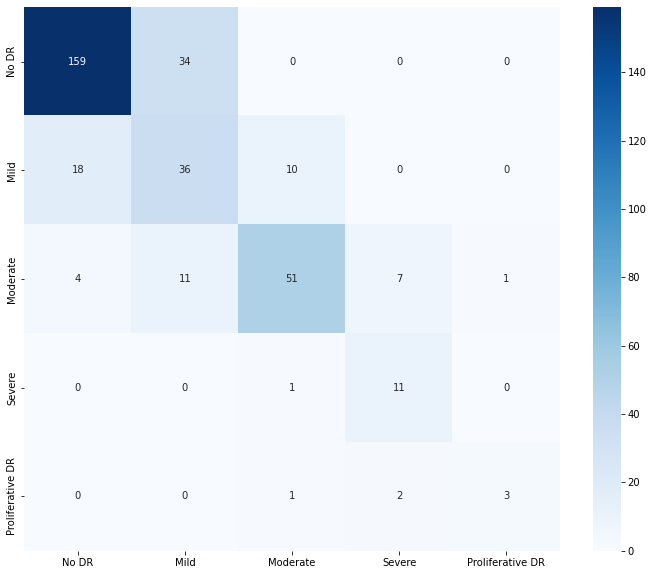

In [16]:
# conf matrix: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

# load model
model = torch.load(MODEL_PATH).to(device)

# prepare to count predictions for each class
predicted = []
actual = []

correct = {diagnosis: 0 for diagnosis in CLASSES}
total = {diagnosis: 0 for diagnosis in CLASSES}

with torch.no_grad():
    for images, labels in test_loader:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Save predictions and actual labels for the confusion matrix
        predicted.extend(predictions.tolist())
        actual.extend(labels.tolist())

        for label, prediction in zip(labels, predictions):
            total[CLASSES[label]] += 1
            if label == prediction:
                correct[CLASSES[label]] += 1
            
# print accuracy for each class
for diagnosis, count in correct.items():
    accuracy = 100 * float(count) / total[diagnosis]
    print(diagnosis, ": ", f"{accuracy:.1f}", "%")

# Build confusion matrix
cf_matrix = confusion_matrix(np.array(actual), np.array(predicted))
df_cm = pd.DataFrame(cf_matrix, index = [i for i in CLASSES],
                     columns = [i for i in CLASSES])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")

# Explainability (GradCAM and GradCAM++)

Actual class:  Mild
Predicted class:  Mild


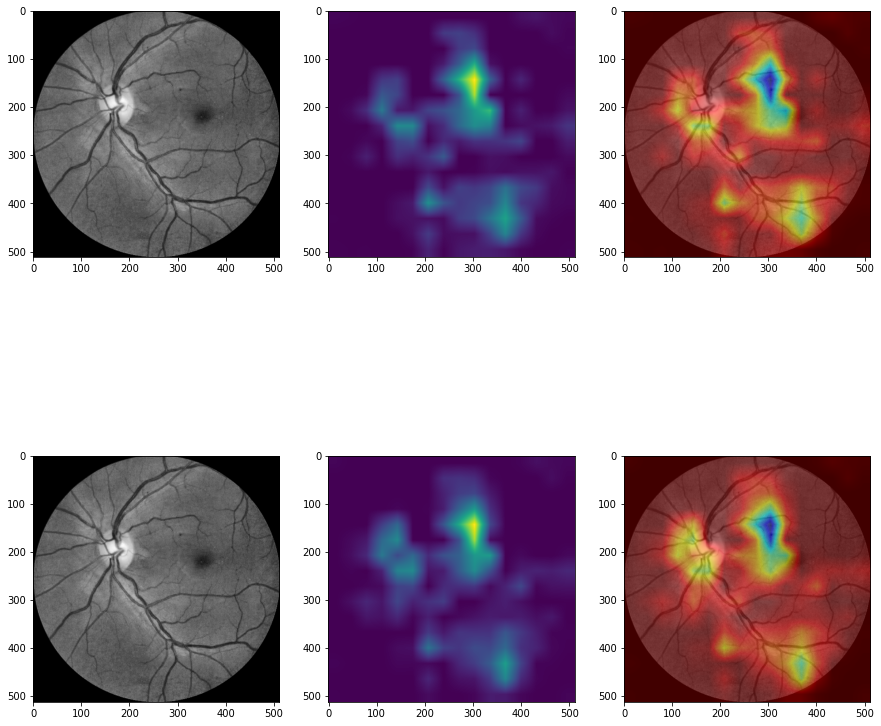

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Retrieve model
dataset = pd.read_csv("messidor_data.csv")
model = torch.load(MODEL_PATH).to(device)
model.eval().to(device)

# Prepare input image
id_code = "eed4afc8ec83"

img = cv2.imread(PREP_PATH + id_code, cv2.COLOR_BGR2RGB)[:, :, ::-1]
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

print("Actual class: ", CLASSES[dataset.loc[dataset['id_code'] == id_code]['diagnosis'].values[0]])
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
print("Predicted class: ", CLASSES[predicted])

# Set target layers
target_layers = [model.features[-1]]

# GradCAM
gradcam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

grayscale_gradcam = gradcam(input_tensor=input_tensor, targets=None , eigen_smooth=False, aug_smooth=False)

grayscale_gradcam = grayscale_gradcam[0, :]

gradcam_image = show_cam_on_image(img, grayscale_gradcam)

# GradCAM++
gradcampp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

grayscale_gradcampp = gradcampp(input_tensor=input_tensor, targets=None , eigen_smooth=False, aug_smooth=False)

grayscale_gradcampp = grayscale_gradcampp[0, :]

gradcampp_image = show_cam_on_image(img, grayscale_gradcampp)

# Visualise results
plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plt.subplots(2,3)

ax[0,0].imshow(img)
ax[0,1].imshow(grayscale_gradcam)
ax[0,2].imshow(gradcam_image)
ax[1,0].imshow(img)
ax[1,1].imshow(grayscale_gradcampp)
ax[1,2].imshow(gradcampp_image)